In [96]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,roc_auc_score,roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.5)

In [2]:
data = pd.read_json('ultimate_data_challenge.json')

In [3]:
data

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [5]:
#Filling in empty values with mean
data.avg_rating_of_driver = data.avg_rating_of_driver.fillna(data.avg_rating_of_driver.mean()).round(2)
data.avg_rating_by_driver = data.avg_rating_by_driver.fillna(data.avg_rating_by_driver.mean().round(2))
data.phone = data.phone.fillna(data.phone.mode()[0])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [7]:
data.signup_date = data.signup_date.astype('datetime64')
data.last_trip_date = data.last_trip_date.astype('datetime64')

In [8]:
#Creating a new column that states whether or not the user was active in the 6th month
data['active_6_mo'] = int()

active_rows = data.last_trip_date.dt.month == 6

data.loc[active_rows,'active_6_mo'] = int(1)
data.loc[~active_rows, 'active_6_mo'] = int(0)

In [9]:
data

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_6_mo
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,1
49996,Astapor,1,2014-01-24,4.6,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0,0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,0


In [10]:
len(data[data.active_6_mo == 1]) / len(data)

0.36512

# Retention

36.5% of users were still active in the 6th month

In [11]:
# These rows are no longer needed
data.drop(columns=['signup_date', 'last_trip_date'], inplace = True)

In [12]:
#One hot encoding city
one_hot_city = pd.get_dummies(data.city,drop_first=True, prefix='city',dtype=int)
data = pd.concat([one_hot_city, data], axis=1)
data.drop(columns=['city'], inplace=True)

In [13]:
#One hot encoding phone type
one_hot_phone = pd.get_dummies(data.phone, drop_first=True, prefix='phone',dtype=int)
data = pd.concat([one_hot_phone, data], axis=1)
data.drop(columns=['phone'], inplace=True)

In [14]:
data

,phone_iPhone,city_King's Landing,city_Winterfell,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_6_mo
0,1,1,0,4,4.7,1.10,15.4,True,46.2,3.67,5.0,1
1,0,0,0,0,5.0,1.00,0.0,False,50.0,8.26,5.0,0
2,1,0,0,3,4.3,1.00,0.0,False,100.0,0.77,5.0,0
3,1,1,0,9,4.6,1.14,20.0,True,80.0,2.36,4.9,1
4,0,0,1,14,4.4,1.19,11.8,False,82.4,3.13,4.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,1,0,0,5.0,1.00,0.0,False,100.0,5.63,4.2,1
49996,1,0,0,1,4.6,1.00,0.0,False,0.0,0.00,4.0,0
49997,0,0,1,0,5.0,1.00,0.0,True,100.0,3.86,5.0,0
49998,1,0,0,2,3.0,1.00,0.0,False,100.0,4.58,3.5,0


In [15]:
X = data.drop(columns='active_6_mo')
y = data.active_6_mo

X_train, X_test, y_train, y_test = train_test_split(X.copy(), y, train_size = .75, random_state=30)

In [16]:
non_binary_cols = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge','surge_pct','weekday_pct', 'avg_dist']#,'avg_rating_by_driver']
scaler = StandardScaler()

X_train[non_binary_cols] = scaler.fit_transform(X_train[non_binary_cols])
X_test[non_binary_cols] = scaler.transform(X_test[non_binary_cols])

In [17]:
X_test

,phone_iPhone,city_King's Landing,city_Winterfell,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
34627,1,1,0,5.482525,0.528354,-0.154510,-0.069277,False,0.144765,-0.694138,4.8
31443,0,0,1,-0.602451,0.706524,-0.334313,-0.441317,False,1.053773,0.221630,5.0
41987,1,1,0,-0.073323,0.350183,0.025292,-0.054194,True,-1.435884,-0.394206,4.8
34402,1,0,0,1.514062,0.172013,-0.334313,-0.441317,True,0.638381,-0.523762,4.9
39027,0,0,0,-0.602451,-0.006158,-0.334313,-0.441317,False,-0.294903,-0.161714,5.0
...,...,...,...,...,...,...,...,...,...,...,...
5294,1,0,1,1.778626,0.706524,1.149059,1.232865,False,1.053773,0.072552,5.0
38876,1,0,1,-0.073323,-0.184328,-0.334313,-0.441317,True,1.053773,0.452347,4.0
31460,1,0,1,-0.602451,0.706524,-0.334313,-0.441317,True,-0.834374,-0.458097,4.9
296,1,0,1,-0.073323,0.706524,-0.334313,-0.441317,False,-0.745361,-0.497141,5.0


# LinearSVC

In [18]:
losses = ['hinge', 'squared_hinge']
duals = [True,False]
learning_rates = list(np.logspace(-3,2,6))
penalties = ['l1','l2']
max_iters = [1000, 5000, 10000, 20000, 50000, 150000]

random_grid = {
    'C': learning_rates,
    'penalty': penalties,
    'max_iter': max_iters,
    'loss': losses,
    'dual': duals
}

svc = LinearSVC()

svc_rand = RandomizedSearchCV(estimator=svc, param_distributions=random_grid, n_iter=50, cv=5, scoring = 'roc_auc', n_jobs=-1,random_state=47)

res = svc_rand.fit(X_train, y_train)

c:\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [19]:
res.best_params_

{'penalty': 'l2',
 'max_iter': 50000,
 'loss': 'squared_hinge',
 'dual': True,
 'C': 100.0}

In [20]:
# In order to compute a ROC score easier, the SVC needs to be wrapped around a CalibratedClassifierCV
svc = LinearSVC(penalty='l2', max_iter=50000, loss='squared_hinge', dual=True, C=100)
clf = CalibratedClassifierCV(svc,cv=5)
clf.fit(X_train, y_train)

c:\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Roc/Auc Score: 0.7523436044587918


c:\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [58]:
# Metrics for test data
y_pred = res.predict(X_test)
print(classification_report(y_test,y_pred))
print('Accuracy:',accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80      8010
           1       0.66      0.45      0.54      4490

    accuracy                           0.72     12500
   macro avg       0.70      0.66      0.67     12500
weighted avg       0.71      0.72      0.70     12500

Accuracy: 0.71896


Text(0.5, 1.0, 'ROC Curve')

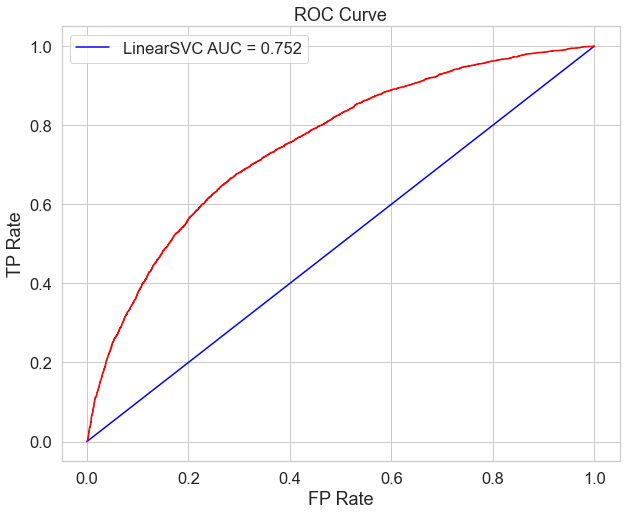

In [87]:
SVC_y_pred_prob = clf.predict_proba(X_test)[:,1]
SVC_score = round(roc_auc_score(y_test,SVC_y_pred_prob),3)

SVC_fpr, SVC_tpr, SVC_thresholds = roc_curve(y_test, SVC_y_pred_prob)

plt.figure(figsize=(10,8))

line_45 = np.linspace(0, 1.0, 20)
plt.plot(line_45, line_45, color='blue')

plt.plot(SVC_fpr, SVC_tpr, color='red')

plt.legend(['LinearSVC AUC = ' + str(SVC_score)],loc='best')
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.title("ROC Curve");

# Random Forest Classifier

In [22]:
RF_model = RandomForestClassifier()
grid = {
    'bootstrap': [True,False],
    'max_depth': [int(x) for x in np.linspace(50, 110,11)] + [None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [int(x) for x in np.linspace(200, 2000,10)]
}
search = RandomizedSearchCV(RF_model, grid, n_iter=10,scoring='roc_auc', cv=5, n_jobs=-1,random_state=47)
results = search.fit(X_train, y_train)

In [23]:
results.best_params_

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 92,
 'bootstrap': False}

In [30]:
RF_model = RandomForestClassifier(n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', max_depth=92, bootstrap=False)
RF_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=92, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=800)

In [71]:
y_pred = RF_model.predict(X_test)
print(classification_report(y_test,y_pred))
print('Accuracy:',accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      8010
           1       0.70      0.64      0.67      4490

    accuracy                           0.77     12500
   macro avg       0.75      0.74      0.75     12500
weighted avg       0.77      0.77      0.77     12500

Accuracy: 0.77232


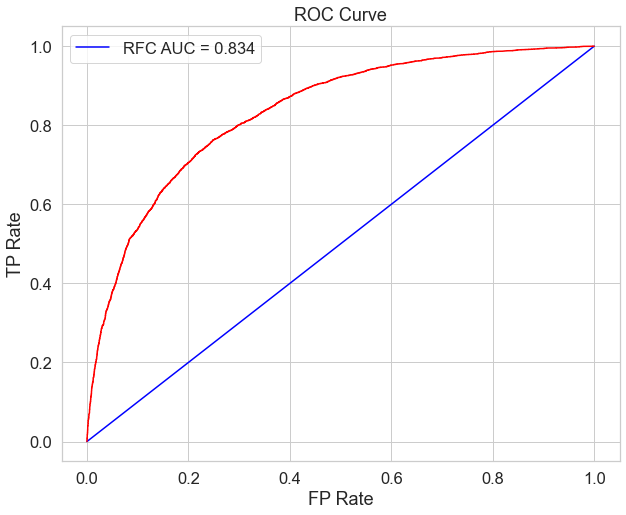

In [88]:
RF_y_pred_prob = results.predict_proba(X_test)[:,1]
RF_score = round(roc_auc_score(y_test,RF_y_pred_prob),3)

RF_fpr, RF_tpr, RF_thresholds = roc_curve(y_test, RF_y_pred_prob)

plt.figure(figsize=(10,8))

line_45 = np.linspace(0, 1.0, 20)
plt.plot(line_45, line_45, color='blue')

plt.plot(RF_fpr, RF_tpr, color='red')

plt.legend(['RFC AUC = ' + str(RF_score)],loc='best')
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.title("ROC Curve");

## Comparison

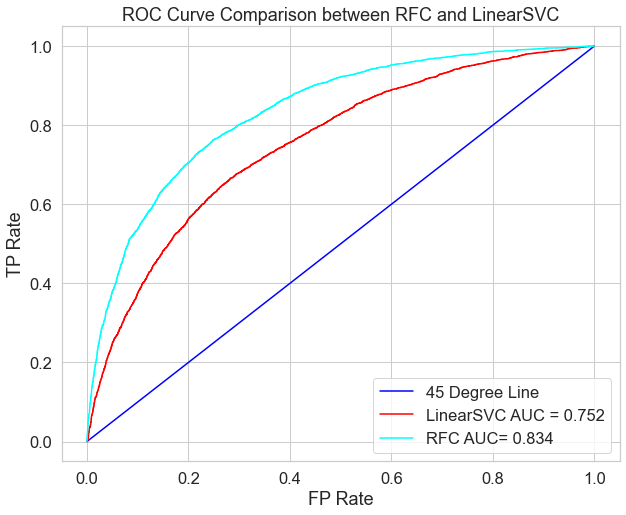

In [90]:
plt.figure(figsize=(10,8))

line_45 = np.linspace(0, 1.0, 20)
plt.plot(line_45, line_45, color='blue')

plt.plot(SVC_fpr, SVC_tpr, color='red')
plt.plot(RF_fpr, RF_tpr, color='cyan')

plt.legend(['45 Degree Line','LinearSVC AUC = ' + str(SVC_score), 'RFC AUC= ' + str(RF_score)],loc='best')
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.title("ROC Curve Comparison between RFC and LinearSVC");

In [97]:
perm_importance = permutation_importance(RF_model, X_test, y_test,n_jobs=-1,n_repeats=20)

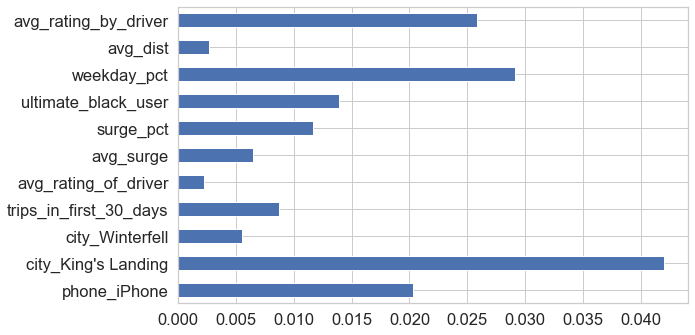

In [98]:
plt.figure(figsize=(10,5))
pd.Series(perm_importance.importances_mean, X_train.columns).plot.barh()
plt.tight_layout()